### In this script, we look for keywords in the metadata of the referenced papers in order to add 4 new variables to the references dataset

### 1. Import the dataset in its post-Pubmed scraping state

In [4]:
import pandas as pd
import os

# Loading the CSV file with references
new_variables = pd.read_csv(os.path.join('..','results','refs_abstracts_sys.csv'))
new_variables.head()

,Author,Title,Abstract,Journal,Year
0,"López-Valenciano A, Ayala F, Puerta JM, et al",A preventive model for muscle injuries: a nove...,The application of contemporary statistical ap...,Medicine and science in sports and exercise,2018.0
1,Li C,Predict the neural network mathematical model ...,Deep learning has achieved impressive predicti...,Physical review letters,2020.0
2,Lu G,Evaluation model of young basketball players ’...,NaN,NaN,NaN
3,Wu L,The participating team ’s technical analysis o...,NaN,NaN,NaN
4,Zhang Q,Prediction based on basketball competition vid...,NaN,NaN,NaN


### 2. Manually define dictionaries of AI techniques, sports, and keywords related to injuries and sports performance, according to the information given in the paper, as well as the keywords we have extracted through topic modeling

In [5]:
# Define dictionary of AI techniques based on Table 2 and their most plausible corresponding aliases
ai_techniques = {
    "Absolute Shrinkage and Selection Operator": ["LASSO", "Least Absolute Shrinkage and Selection Operator", "L1 Regularization"],
    "Artificial Neural Network": ["ANN", "Neural Net", "Deep Learning", "Perceptron", 
                                  "Self-organising map", "Self-organizing map", "SOM"],
    "Bayesian Logistic": ["Bayesian Regression", "Bayesian Model"],
    "Bayesian Network": ["Bayesian Belief", "Belief Net", "Bayes Net", 
                          "Probabilistic Directed Acyclic Graphical Model"],
    "Decision Tree Classifier": ["Decision Tree", "Classification Tree", "Tree Classifier", 
                                 "Classification And Regression Tree", "CART"],
    "Fuzzy Clustering": ["Fuzzy C-means", "Soft Clustering", "Fuzzy K-means", "C-Means Clustering"],
    "K-means Clustering": ["K-means", "Lloyd's Algorithm", "Hard Clustering", "Centroid-based Clustering"],
    "K-nearest Neighbor": ["KNN", "K-nearest", "Instance-based Learning", "Lazy Learning"],
    "Markov Process": ["Markov Chain", "Markov Model"],
    "Support Vector Machine": ["SVM", "Support Vector Classifier", "Support Vector Networks", "Kernel Methods"]
}

# Define dictionary of sports used in the research along with their aliases
sports = {
    "Basketball": ["Basket"],
    "Soccer": ["Association Football"],
    "Volleyball": ["Volley"],
    "Baseball": ["MLB"],
    "Handball": [],
    "Australian Football": ["AFL Football"],
    "Ice Hockey": ["Hockey", "NHL", "Stanley Cup"],
    "American Football": ["NFL Football", "College Football"],
    "Cricket": ["IPL Bowl"],
    "Field Hockey": [],
    "Rugby": []
}

# Define stemmatized keywords to help us decide which papers are related to injuries and/or to sporting performance
injury_keywords = ["injur", "medic", "risk", "prevent", "diagnosis", "detection"]
perf_keywords = ["performance", "techni", "tactical", "match", "position",
                 "possession", "ranking", "team", "skill", "game", "win"]

### 3. Search for the keywords we have defined inside of the dataset, and add the 4 new variables (AI Technique, Sport, AI for Injury Risk, AI for Sporting Performance)

In [6]:
# Define a function that will find instances of a certain item from a dictionary in text (non-exact matches allowed)
def find_dictionary(text, dictionary):
    found = []
    for item, aliases in dictionary.items():
        if item.lower() in text.lower() or any(alias.lower() in text.lower() for alias in aliases):
            found.append(item)
    return found

# Function to identify if AI is used for sporting performance prediction or injury risk
def ai_logical(text, keywords):
    for key in keywords:
        if key in text.lower():
            return "Yes"
    return "No"

# Process the dataset
ai_techniques_col = []
sports_col = []
ai_for_injury_risk_col = []
ai_for_performance_col = []

for index, paper in new_variables.iterrows():
    text = str(paper['Title']) + ' ' + str(paper['Abstract']) + ' ' + str(paper['Journal'])

    # Find AI techniques and sports
    ai_techniques_list = find_dictionary(text, ai_techniques)
    sports_list = find_dictionary(text, sports)

    # Convert to string, or use None if the list is empty    
    ai_techniques_col.append(' + '.join(ai_techniques_list) if ai_techniques_list else pd.NA)
    sports_col.append(', '.join(sports_list) if sports_list else pd.NA)
    ai_for_injury_risk_col.append(ai_logical(text, injury_keywords))
    ai_for_performance_col.append(ai_logical(text, perf_keywords))

# Adding new columns to the dataset
new_variables['AI Techniques'] = ai_techniques_col
new_variables['Sports'] = sports_col
new_variables['AI for Injury Risk'] = ai_for_injury_risk_col
new_variables['AI for Performance'] = ai_for_performance_col

# Exporting the updated dataset to csv
new_variables.to_csv(os.path.join('..','results','new_variables.csv'), index=False)

new_variables.head()


,Author,Title,Abstract,Journal,Year,AI Techniques,Sports,AI for Injury Risk,AI for Performance
0,"López-Valenciano A, Ayala F, Puerta JM, et al",A preventive model for muscle injuries: a nove...,The application of contemporary statistical ap...,Medicine and science in sports and exercise,2018.0,<NA>,<NA>,Yes,No
1,Li C,Predict the neural network mathematical model ...,Deep learning has achieved impressive predicti...,Physical review letters,2020.0,Artificial Neural Network,Basketball,No,Yes
2,Lu G,Evaluation model of young basketball players ’...,NaN,NaN,NaN,Artificial Neural Network,Basketball,No,Yes
3,Wu L,The participating team ’s technical analysis o...,NaN,NaN,NaN,Artificial Neural Network,Basketball,No,Yes
4,Zhang Q,Prediction based on basketball competition vid...,NaN,NaN,NaN,Artificial Neural Network,Basketball,No,No


### 4. Plot the most common sports and AI techniques in the dataset and investigate what they were used for

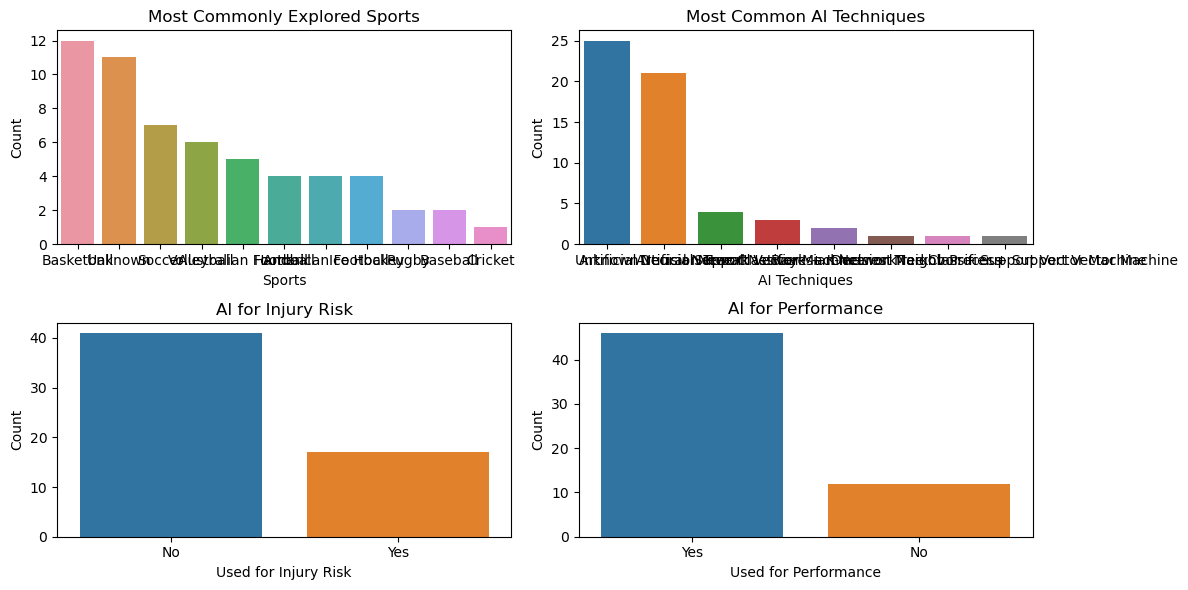

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plots_df = new_variables.fillna("Unknown")

# Adding a new column to the dataset based on the specified criteria
def categorize(row):
    if row['AI for Injury Risk'] == "Yes" and row['AI for Performance'] == "Yes":
        return "Injuries & Performance"
    elif row['AI for Injury Risk'] == "Yes":
        return "Injury Risk"
    elif row['AI for Performance'] == "Yes":
        return "Performance"
    else:
        return "Unknown"

plots_df['AI Usage'] = plots_df.apply(categorize, axis=1)

# Counting the occurrences of different sports and AI techniques
sports_count = plots_df['Sports'].value_counts()
ai_techniques_count = plots_df['AI Techniques'].value_counts()

# Counting the occurrences of AI for Injury Risk and AI for Performance
ai_injury_risk_count = plots_df['AI for Injury Risk'].value_counts()
ai_performance_count = plots_df['AI for Performance'].value_counts()

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.barplot(x=sports_count.index, y=sports_count.values)
plt.title("Most Commonly Explored Sports")
plt.xlabel("Sports")
plt.ylabel("Count")

plt.subplot(2, 2, 2)
sns.barplot(x=ai_techniques_count.index, y=ai_techniques_count.values)
plt.title("Most Common AI Techniques")
plt.xlabel("AI Techniques")
plt.ylabel("Count")

plt.subplot(2, 2, 3)
sns.barplot(x=ai_injury_risk_count.index, y=ai_injury_risk_count.values)
plt.title("AI for Injury Risk")
plt.xlabel("Used for Injury Risk")
plt.ylabel("Count")

plt.subplot(2, 2, 4)
sns.barplot(x=ai_performance_count.index, y=ai_performance_count.values)
plt.title("AI for Performance")
plt.xlabel("Used for Performance")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

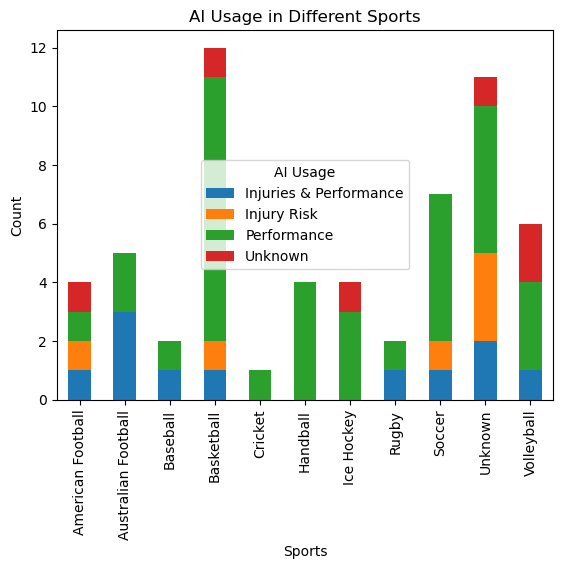

<Figure size 1000x600 with 0 Axes>

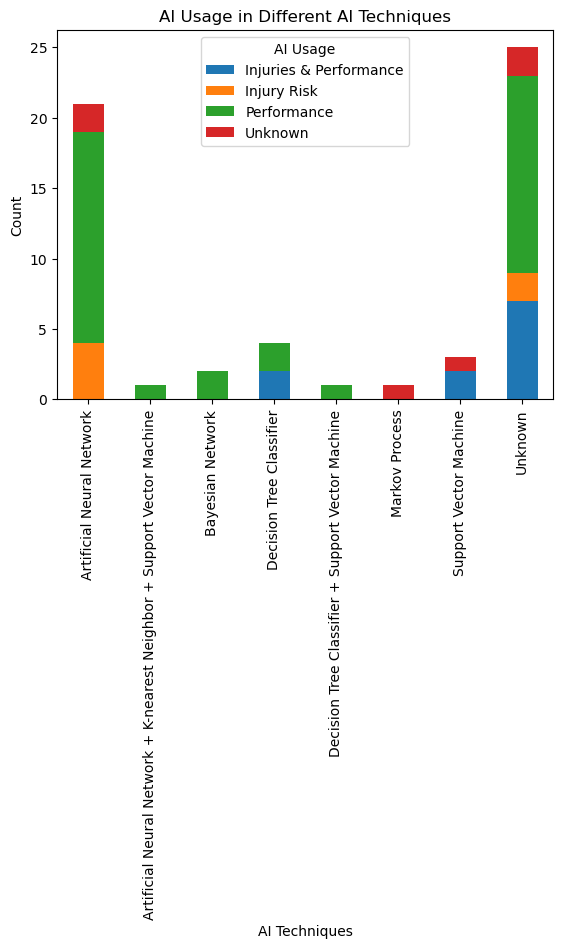

<Figure size 1000x600 with 0 Axes>

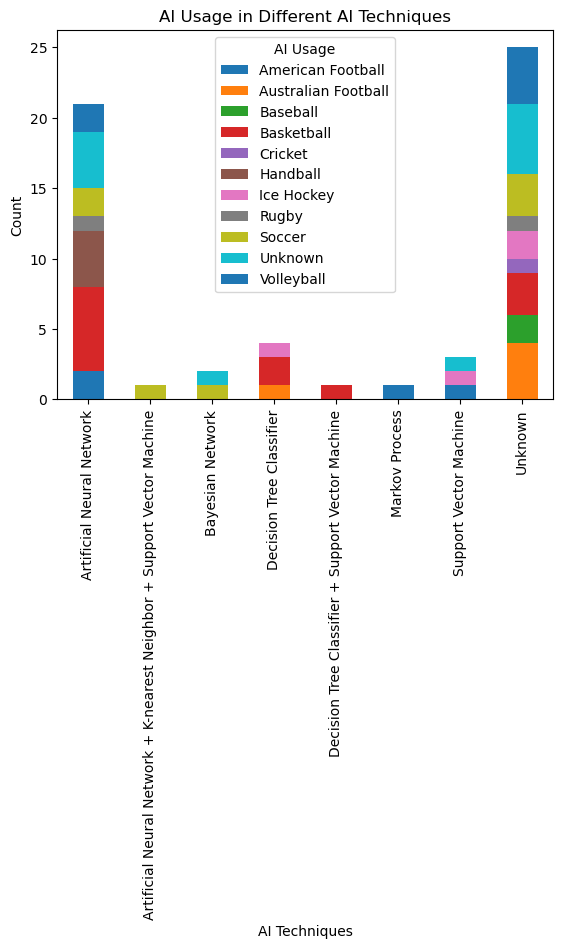

In [17]:
# Preparing data for stacked bar plots for AI Techniques
stacked_data_tech = plots_df.groupby(['AI Techniques', 'AI Usage']).size().unstack().fillna(0)

# Plotting stacked bar plot for AI Usage in different AI Techniques
plt.figure(figsize=(10, 6))
stacked_data_tech.plot(kind='bar', stacked=True)
plt.title("AI Usage in Different AI Techniques")
plt.xlabel("AI Techniques")
plt.ylabel("Count")
plt.legend(title='AI Usage')
plt.show()

stacked_data_techsports = plots_df.groupby(['AI Techniques', 'Sports']).size().unstack().fillna(0)

# Plotting stacked bar plot for AI Usage in different AI Techniques
plt.figure(figsize=(10, 6))
stacked_data_techsports.plot(kind='bar', stacked=True)
plt.title("AI Usage in Different AI Techniques")
plt.xlabel("AI Techniques")
plt.ylabel("Count")
plt.legend(title='AI Usage')
plt.show()